# EE782 - ADVANCE ML

## VRINDA GOEL(20D070090)

In [ ]:
#pd.set_option('display.max_rows', None)

In [3]:
pip install mplfinance

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt
import torch
import torch.nn as nn
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import mplfinance as mpf
import copy
import statistics
from statistics import stdev

## Data Preparation:
I have considered 3 stocks: AA, AAPL and AVGO for analysis

In [5]:
df1 = pd.read_csv('AAPL_1min.txt')
df1.to_csv('AAPL_1min.csv')

In [6]:
df2 = pd.read_csv('AA_1min.txt')
df2.to_csv('AA_1min.csv')

In [7]:
df3 = pd.read_csv('AVGO_1min.txt')
df3.to_csv('AVGO_1min.csv')

In [72]:
datasets = ['AA','AVGO','AAPL']
data_dict_minbymin = {} ## to store minute by minute data of each stock
data_dict_daybyday = {} ## to store day by day data of each stock
data_dict_yearbyyear = {} ## to store year by year data of each stock
for file in datasets:
  data = pd.read_csv(f'{file}_1min.csv',header = None, names = ['Date&Time','Open','High','Low','Close','Volume']) # read each csv file
  data = data.reset_index()
  data['Timestamp'] = pd.to_datetime(data['Date&Time'])
  data.set_index('Timestamp',inplace = True)
  data = data.drop(['index','Date&Time'],axis =1)
  resampled_data = data.resample('1T').ffill() #resample it to minute by minute level
  mask0 = (resampled_data.index.time >= pd.to_datetime('9:30 AM').time()) & (resampled_data.index.time <= pd.to_datetime('4:00 PM').time()) #consider time between 9:30 - 4pm only
  resampled_data=resampled_data[mask0]
  start_datetime1 = pd.to_datetime('2022-02-23 09:30 AM')
  end_datetime1 = pd.to_datetime('2022-02-23 04:00 PM')
  mask1 = (resampled_data.index >= start_datetime1) & (resampled_data.index <= end_datetime1)
  data_filtered1 = resampled_data[mask1]
  data_dict_minbymin[file]=data_filtered1
  data_dict_minbymin[file]=data_dict_minbymin[file].astype(float)
  start_datetime2 = pd.to_datetime('2016-10-18 09:30 AM')
  end_datetime2 = pd.to_datetime('2022-02-25 04:00 PM')
  mask2 = (resampled_data.index >= start_datetime2) & (resampled_data.index <= end_datetime2)
  data_filtered2 = resampled_data[mask2]
  day_data = data_filtered2.resample('D').last() #resample it to day by day level
  data_dict_daybyday[file]= day_data
  data_dict_daybyday[file]=data_dict_daybyday[file].astype(float)
  month_data = day_data.resample('M').last()
  data_dict_yearbyyear[file]= month_data
  data_dict_yearbyyear[file]=data_dict_yearbyyear[file].astype(float)

<ipython-input-72-ad3af57cb0e7>:6: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'{file}_1min.csv',header = None, names = ['Date&Time','Open','High','Low','Close','Volume']) # read each csv file
<ipython-input-72-ad3af57cb0e7>:6: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'{file}_1min.csv',header = None, names = ['Date&Time','Open','High','Low','Close','Volume']) # read each csv file
<ipython-input-72-ad3af57cb0e7>:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'{file}_1min.csv',header = None, names = ['Date&Time','Open','High','Low','Close','Volume']) # read each csv file


In [9]:
data_dict_daybyday['AA']

,Open,High,Low,Close,Volume
Timestamp,,,,,
2016-10-18,26.3487,26.3487,26.3487,26.3487,609222.0
2016-10-19,26.8755,26.8755,26.8755,26.8755,376148.0
2016-10-20,26.5276,26.5276,26.5276,26.5276,316027.0
2016-10-21,26.7165,26.7165,26.7165,26.7165,312003.0
2016-10-22,26.7662,26.7662,26.7662,26.7662,100.0
...,...,...,...,...,...
2022-02-21,78.1500,78.1500,78.1500,78.1500,100.0
2022-02-22,74.0900,74.0900,74.0900,74.0900,223215.0
2022-02-23,75.3200,75.3200,75.3000,75.3200,207715.0


In [ ]:
data_dict_daybyday['AAPL']

,Open,High,Low,Close,Volume
Timestamp,,,,,
2016-10-18,27.4666,27.4666,27.4456,27.4456,5861080.0
2016-10-19,27.3848,27.3872,27.3778,27.3848,4196668.0
2016-10-20,27.3591,27.3708,27.3591,27.3614,5060912.0
2016-10-21,27.2632,27.2632,27.2422,27.2632,7234784.0
2016-10-22,27.2492,27.2492,27.2492,27.2492,6440.0
...,...,...,...,...,...
2022-02-21,166.4500,166.5000,166.4500,166.5000,1428.0
2022-02-22,164.3200,164.6600,164.3200,164.6100,6193443.0
2022-02-23,160.0800,160.6200,160.0700,160.4000,8533985.0


# **QUESTION: 1**

## **Ques 1: Familiarize yourself with the input data**
### **a) Plot the minute by minute closing price of few stocks**
### **b) Plot the day-by-day closing price of a few stocks**
### **c) Plot a complete candlestick chart with volume on secondary y-axis for a few stocks with a time period of your choice**
### **d) Note down your observations, e.g. are there any data issues, unexpected jumps, unexpected missing data etc.**


## a) Plot the minute by minute closing price of few stocks
## (Showed for 1 day for better visualisation of minute by minute movement of price)

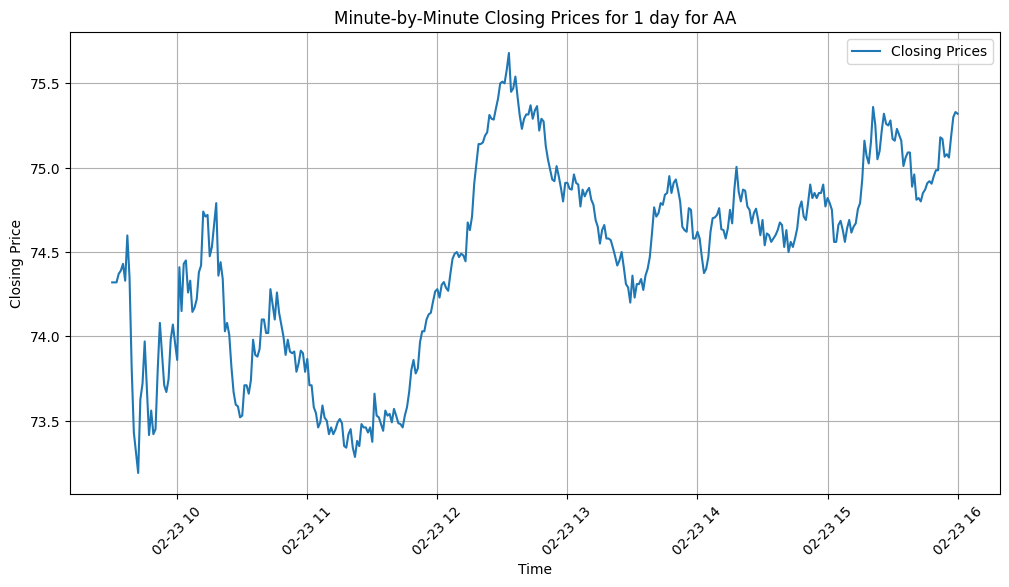

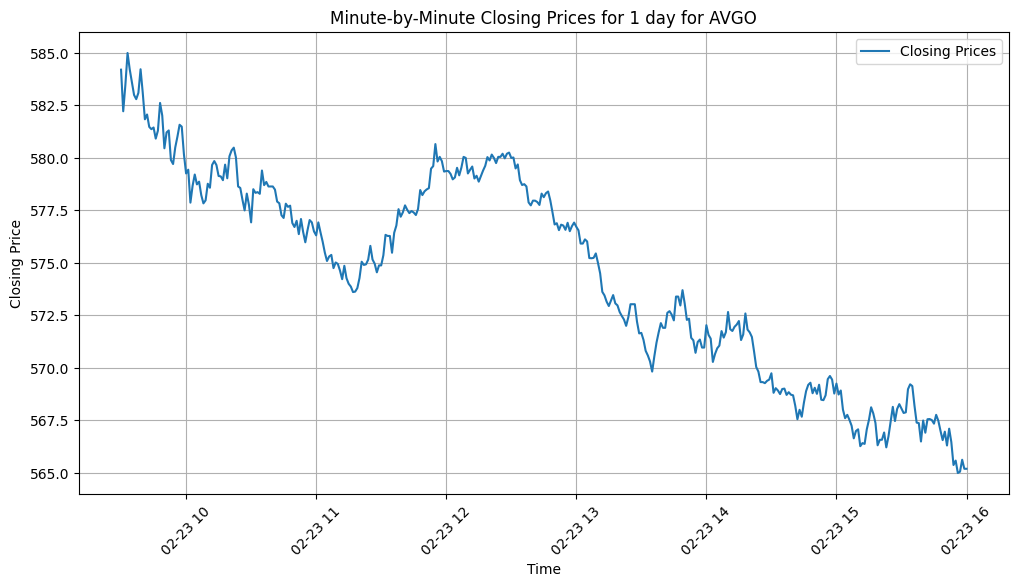

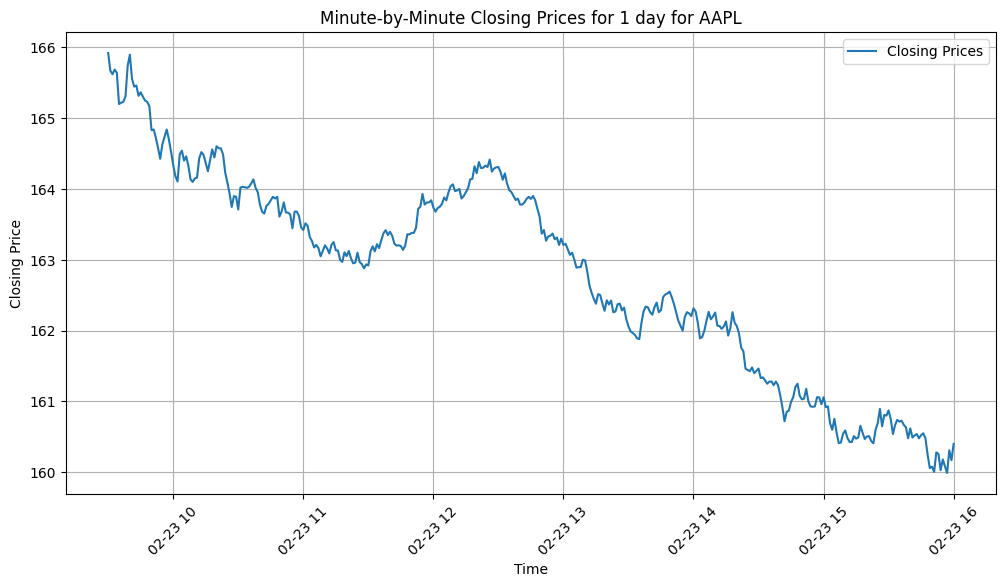

In [ ]:
for key in data_dict_minbymin.keys():
  plt.figure(figsize=(12, 6))
  plt.plot(data_dict_minbymin[key].index, data_dict_minbymin[key]['Close'], label='Closing Prices')
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.xlabel('Time')
  plt.ylabel('Closing Price')
  plt.title(f'Minute-by-Minute Closing Prices for 1 day for {key}')
  plt.legend()
  plt.grid(True)
  plt.show()

## b) Plot the day by day closing price of few stocks

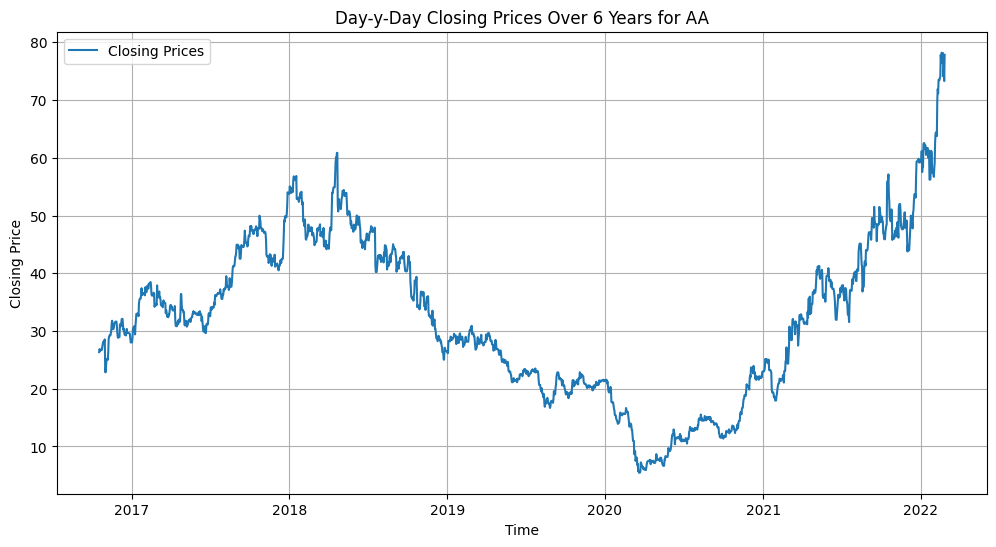

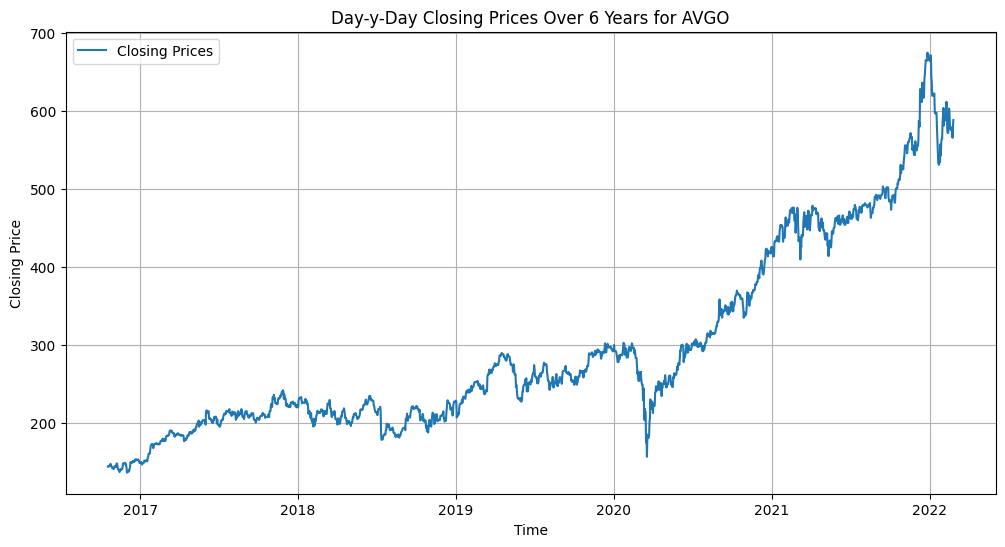

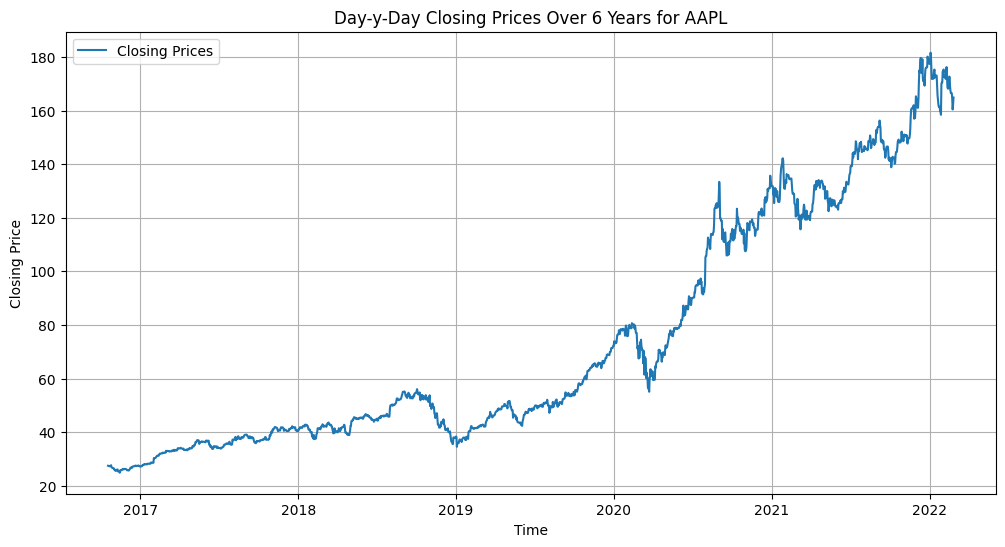

In [ ]:
for key in data_dict_daybyday.keys():
  plt.figure(figsize=(12, 6))
  plt.plot(data_dict_daybyday[key].index, data_dict_daybyday[key]['Close'], label='Closing Prices')
  plt.xlabel('Time')
  plt.ylabel('Closing Price')
  plt.title(f'Day-y-Day Closing Prices Over 6 Years for {key}')
  plt.legend()
  plt.grid(True)
  plt.show()


## c)Plot a complete candlestick chart with volume on secondary y-axis for a few stocks with a time period of your choice

In [ ]:
df1=data_dict_daybyday['AAPL']
df2=data_dict_daybyday['AA']
df3=data_dict_daybyday['AVGO']

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

##AAPL
#--------------------------------------------------------------------
# Create subplots and mention plot grid size
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
               vertical_spacing=0.03, subplot_titles=('OHLC(AAPL)', 'Volume'),
               row_width=[0.2, 0.7])

# Plot OHLC on 1st row
fig.add_trace(go.Candlestick(x=df1.index, open=df1["Open"], high=df1["High"],
                low=df1["Low"], close=df1["Close"], name="OHLC(AAPL)"),
                row=1, col=1
)

# Bar trace for volumes on 2nd row without legend
fig.add_trace(go.Bar(x=df1.index, y=df1['Volume'], showlegend=False), row=2, col=1)

# Do not show OHLC's rangeslider plot
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()
#-----------------------------------------------------------------------
## AA

# Create subplots and mention plot grid size
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
               vertical_spacing=0.03, subplot_titles=('OHLC(AA)', 'Volume'),
               row_width=[0.2, 0.7])

# Plot OHLC on 1st row
fig.add_trace(go.Candlestick(x=df2.index, open=df2["Open"], high=df2["High"],
                low=df2["Low"], close=df2["Close"], name="OHLC(AA)"),
                row=1, col=1
)

# Bar trace for volumes on 2nd row without legend
fig.add_trace(go.Bar(x=df2.index, y=df2['Volume'], showlegend=False), row=2, col=1)

# Do not show OHLC's rangeslider plot
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()
#----------------------------------------------------------------------------
## AVGO

# Create subplots and mention plot grid size
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
               vertical_spacing=0.03, subplot_titles=('OHLC(AVGO)', 'Volume'),
               row_width=[0.2, 0.7])

# Plot OHLC on 1st row
fig.add_trace(go.Candlestick(x=df3.index, open=df3["Open"], high=df3["High"],
                low=df3["Low"], close=df3["Close"], name="OHLC(AVGO)"),
                row=1, col=1
)

# Bar trace for volumes on 2nd row without legend
fig.add_trace(go.Bar(x=df3.index, y=df3['Volume'], showlegend=False), row=2, col=1)

# Do not show OHLC's rangeslider plot
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()
#----------------------------------------------------------------------------

## d) Note down your observations, e.g. are there any data issues, unexpected jumps, unexpected missing data etc.

## *There was missing data encountered in some datasets (For example: AA). It was expected to have minute by minute data but many entries were missing. That's why while plotting minute by minute data, I had to resample it to minute level while using **ffill()** method that takes the previous value for all the missing minute values.*


### Other ways of plotting candlestick charts (Can be ignored, was just trying different ways for clarity:



In [ ]:
## AAPL
data_1yr_aapl= data_dict_daybyday['AAPL'].tail(366)
data_1yr_aapl['Timestamp']=data_1yr_aapl.index
# Reorder columns to make 'Index_Copy' the first column
data_1yr_aapl = data_1yr_aapl[['Timestamp'] + [col for col in data_1yr_aapl.columns if col != 'Timestamp']]
data_1yr_aapl.info()
## AA
data_1yr_aa= data_dict_daybyday['AA'].tail(366)
data_1yr_aa['Timestamp']=data_1yr_aa.index
# Reorder columns to make 'Index_Copy' the first column
data_1yr_aa = data_1yr_aa[['Timestamp'] + [col for col in data_1yr_aa.columns if col != 'Timestamp']]
data_1yr_aa.info()
## AVGO
data_1yr_avgo= data_dict_daybyday['AVGO'].tail(366)
data_1yr_avgo['Timestamp']=data_1yr_avgo.index
# Reorder columns to make 'Index_Copy' the first column
data_1yr_avgo = data_1yr_avgo[['Timestamp'] + [col for col in data_1yr_avgo.columns if col != 'Timestamp']]
data_1yr_avgo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2021-02-25 to 2022-02-25
Freq: D
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  366 non-null    datetime64[ns]
 1   Open       366 non-null    float64       
 2   High       366 non-null    float64       
 3   Low        366 non-null    float64       
 4   Close      366 non-null    float64       
 5   Volume     366 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 20.0 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2021-02-25 to 2022-02-25
Freq: D
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  366 non-null    datetime64[ns]
 1   Open       366 non-null    float64       
 2   High       366 non-null    float64       
 3   Low        366 non-null    float64       
 4   Close      366 

<ipython-input-17-a46f73fedc3f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1yr_aapl['Timestamp']=data_1yr_aapl.index
<ipython-input-17-a46f73fedc3f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1yr_aa['Timestamp']=data_1yr_aa.index
<ipython-input-17-a46f73fedc3f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

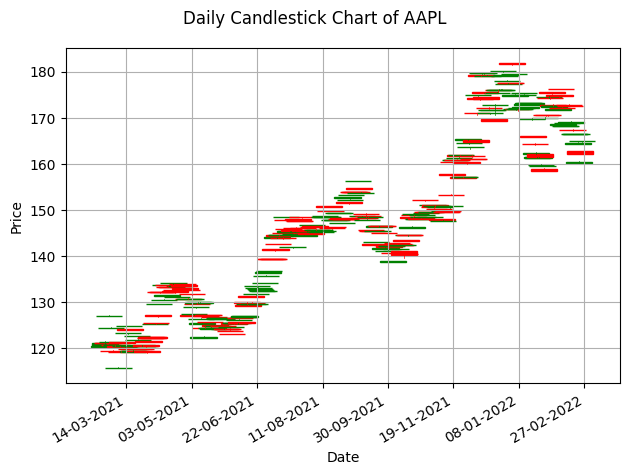

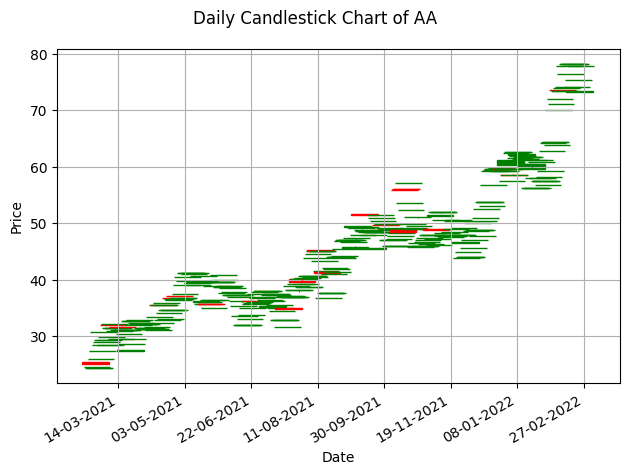

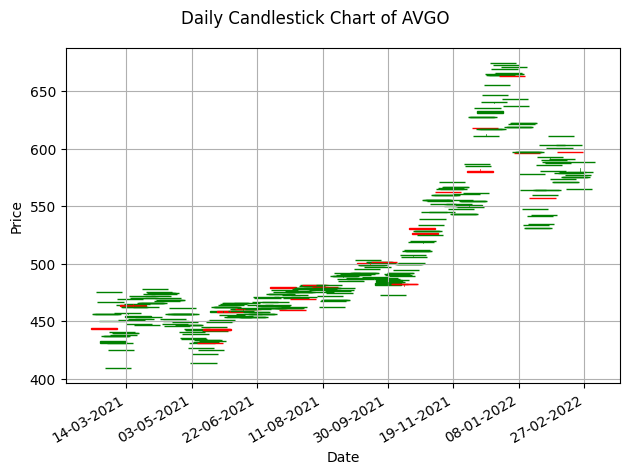

In [ ]:
# Converting date into datetime format
data_1yr_aapl['Timestamp'] = data_1yr_aapl['Timestamp'].apply(mpl_dates.date2num)
data_1yr_aapl = data_1yr_aapl.astype(float)
fig, ax = plt.subplots()
candlestick_ohlc(ax, data_1yr_aapl.values, width=20,
                 colorup='green', colordown='red', alpha=1)

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('Daily Candlestick Chart of AAPL')
# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()
plt.grid(True)
plt.show()

## AA
# Converting date into datetime format
data_1yr_aa['Timestamp'] = data_1yr_aa['Timestamp'].apply(mpl_dates.date2num)
data_1yr_aa = data_1yr_aa.astype(float)
fig, ax = plt.subplots()
candlestick_ohlc(ax, data_1yr_aa.values, width=20,
                 colorup='green', colordown='red', alpha=1)

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('Daily Candlestick Chart of AA')
# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()
plt.grid(True)
plt.show()

## AVGO
# Converting date into datetime format
data_1yr_avgo['Timestamp'] = data_1yr_avgo['Timestamp'].apply(mpl_dates.date2num)
data_1yr_avgo = data_1yr_avgo.astype(float)
fig, ax = plt.subplots()
candlestick_ohlc(ax, data_1yr_avgo.values, width=20,
                 colorup='green', colordown='red', alpha=1)
# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('Daily Candlestick Chart of AVGO')
# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()
plt.grid(True)
plt.show()

# **QUESTION: 2**

## **Ques 2) Try at least two ways to normalize the data as stock prices and volume change over time and are different across companies, and pick one by noting your justification.**

### 1) MinMaxScaler (regularization) - converts all values in range [0,1]
*   It is useful when you need all features to have the same scale
*   Calculated as normalized values = (x - min(x)) / (max(x) - min(x))
*   It is sensitive to outliers

### 2) Z-score (standardization)
*   Z-score scales data to have a mean of 0 and a standard deviation of 1
*   Calculated as std values = (x - mean(x)) / std_dev(x)
*   Robust to outliers







## 1) Minmax Scaler

In [ ]:
aapl_day_minmax = copy.deepcopy(data_dict_daybyday['AAPL'])
cols = aapl_day_minmax.columns
print(cols)

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [ ]:
for col in cols:
  aapl_day_minmax[f"{col}_normalized"] = aapl_day_minmax[col] - aapl_day_minmax[col].min()/(aapl_day_minmax[col].max()-aapl_day_minmax[col].min())

## 2) Z-Score

In [ ]:
aapl_day_zscore = copy.deepcopy(data_dict_daybyday['AAPL'])
colms = aapl_day_zscore.columns
print(colms)

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [ ]:
for col in colms:
  aapl_day_zscore[f"{col}_normalized"] = ((aapl_day_zscore[col] - aapl_day_zscore[col].mean())/stdev(aapl_day_zscore[col]))

In [ ]:
aapl_day_zscore

,Open,High,Low,Close,Volume,Open_normalized,High_normalized,Low_normalized,Close_normalized,Volume_normalized
Timestamp,,,,,,,,,,
2016-10-18,27.4666,27.4666,27.4456,27.4456,5861080.0,-1.066941,-1.067190,-1.067218,-1.067449,-0.075973
2016-10-19,27.3848,27.3872,27.3778,27.3848,4196668.0,-1.068807,-1.069000,-1.068766,-1.068836,-0.277242
2016-10-20,27.3591,27.3708,27.3591,27.3614,5060912.0,-1.069393,-1.069374,-1.069193,-1.069370,-0.172733
2016-10-21,27.2632,27.2632,27.2422,27.2632,7234784.0,-1.071580,-1.071826,-1.071861,-1.071610,0.090143
2016-10-22,27.2492,27.2492,27.2492,27.2492,6440.0,-1.071900,-1.072146,-1.071702,-1.071929,-0.783947
...,...,...,...,...,...,...,...,...,...,...
2022-02-21,166.4500,166.5000,166.4500,166.5000,1428.0,2.103149,2.102088,2.105876,2.104495,-0.784553
2022-02-22,164.3200,164.6600,164.3200,164.6100,6193443.0,2.054565,2.060145,2.057254,2.061382,-0.035782
2022-02-23,160.0800,160.6200,160.0700,160.4000,8533985.0,1.957854,1.968053,1.960238,1.965349,0.247249


### I have used z-score in my calculations as it is robust to outliers and it preserves the distribution since in stock markets, **data very rarely follow gaussian distribution and is mostly skewed**.

# **QUESTION:3**

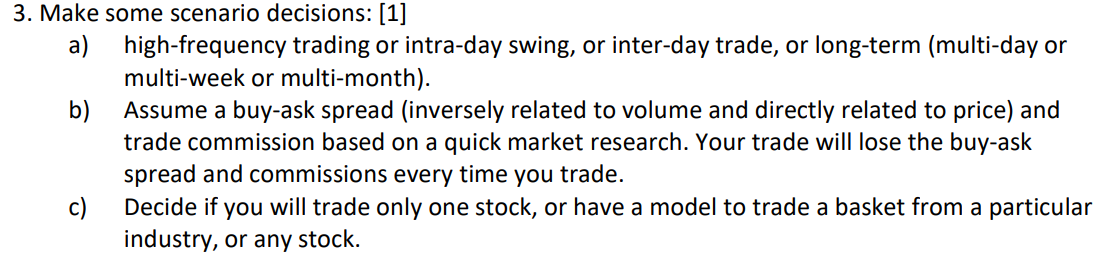

## a) I have used long term trading(from 2016 onwards)
## b) Though bid ask spread might vary since if liquidity is high(stock has high liquidity) then we will have multiple buyers and sellers in the order book and thus there will be tighter bid ask spread, but here I have assumed it to be 1% per trade  and commission is assumed to be 0.5 percent of trade value
## c) I have used AVGO along with AA and AAPL since AVGO is related to AAPL

## **Ques 4) Write a pytorch module for defining an LSTM model. Keep it flexible so that the input dimension, number of units, number of layers can be easily changed**

In [73]:
## specify the desired dimensions of model here
input_dim = 5
hidden_dim = 32
num_layers = 2
output_dim = 5

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
## using MSE Loss function and Adam Optimizer
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(5, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=5, bias=True)
)
10
torch.Size([128, 5])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([5, 32])
torch.Size([5])


In [74]:
features= ['Open', 'High', 'Low', 'Close', 'Volume']
stocks=['AA','AAPL','AVGO']
data_dict_daybyday_std={}
data_dict_daybyday_scaled={}
for stock in stocks:
  df_std= copy.deepcopy(data_dict_daybyday[stock])
  scaler = StandardScaler()
  df_std[features] = scaler.fit_transform(data_dict_daybyday[stock][features])
  data_dict_daybyday_std[stock]=df_std
  data_dict_daybyday_scaled[stock]=scaler

In [75]:
data_dict_daybyday_std['AA']

,Open,High,Low,Close,Volume
Timestamp,,,,,
2016-10-18,-0.431423,-0.432233,-0.430715,-0.431519,0.793990
2016-10-19,-0.393765,-0.394584,-0.393054,-0.393870,0.379430
2016-10-20,-0.418634,-0.419447,-0.417925,-0.418734,0.272496
2016-10-21,-0.405131,-0.405947,-0.404421,-0.405233,0.265338
2016-10-22,-0.401578,-0.402395,-0.400868,-0.401681,-0.289431
...,...,...,...,...,...
2022-02-21,3.271596,3.269826,3.272583,3.270590,-0.289431
2022-02-22,2.981367,2.979672,2.982332,2.980432,0.107415
2022-02-23,3.069293,3.067576,3.068835,3.068337,0.079845


# **QUESTION: 5**

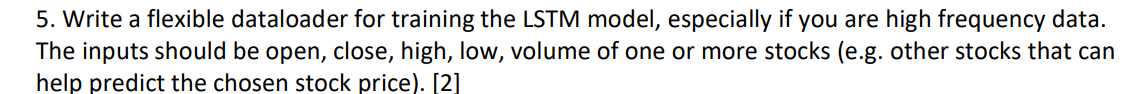

##Trained upto year 2020 and left next 2 years for testing
##Ratio of 0.354 splits it into desired portion
## Future horizon by default is taken to be 1, but it can be modified


In [76]:
import numpy as np
import pandas as pd

def load_stock_data(dataframes, stock, related_stocks=[],
                    stock_features=['Open', 'High', 'Low', 'Close', 'Volume'],
                    related_stocks_features=[],
                    look_back=60, future_horizon=1):

    def final_data():
        dataframe_stock = dataframes[stock]
        data_raw = dataframe_stock[stock_features]

        for additional_stock in related_stocks:
            additional_stock_dataframe = dataframes[additional_stock]
            data_raw = pd.merge(data_raw, additional_stock_dataframe[related_stocks_features], left_index=True, right_index=True)

        data_raw = data_raw.values
        return data_raw

    data_raw = final_data()
    data = []

    for index in range(len(data_raw) - look_back - future_horizon):
        data.append(data_raw[index: index + look_back + future_horizon])

    data = np.array(data)
    test_set_size = int(np.round(0.354 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    x_train = data[:train_set_size, :-future_horizon, :]
    y_train = data[:train_set_size, -1, :len(stock_features)]

    x_test = data[train_set_size:, :-future_horizon, :]
    y_test = data[train_set_size:, -1, :len(stock_features)]

    return x_train, y_train, x_test, y_test


# dataframes = {'AAPL': pd.DataFrame(), 'AA': pd.DataFrame(), 'AVGO': pd.DataFrame()}
# stock = 'AAPL'
# additional_stocks = ['AA', 'AVGO']
# x_train, y_train, x_test, y_test = load_stock_data(dataframes, stock, additional_stocks)


In [177]:
# load_stock_data takes (close,open,high,low,volume) of one or more stocks as input and split the dataset accordingly
[x_train, y_train, x_test, y_test]=load_stock_data(data_dict_daybyday_std, stock="AA",stock_features=['Open', 'High', 'Low', 'Close', 'Volume'],
                                                   related_stocks=[],look_back=60,future_horizon=1)
x_train_tensor = torch.from_numpy(x_train).type(torch.Tensor)
x_test_tensor = torch.from_numpy(x_test).type(torch.Tensor)
y_train_tensor = torch.from_numpy(y_train).type(torch.Tensor)
y_test_tensor = torch.from_numpy(y_test).type(torch.Tensor)

# **QUESTION: 6**

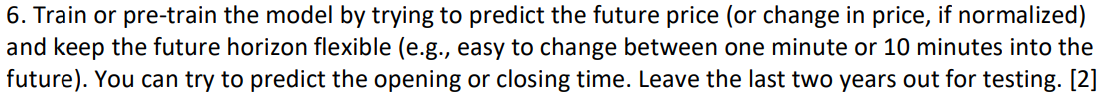

In [178]:
def training(stock,x_train_tensor,y_train_tensor,input_dim, hidden_dim, output_dim, num_layers):
    num_epochs = 100
    hist = np.zeros(num_epochs)
    print(f"Training for {stock} starts")
    model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    loss_fn = torch.nn.MSELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

    training_loss = np.zeros(num_epochs)
    # Number of steps to unroll
    #seq_dim =look_back-1
    for t in range(num_epochs):
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        #model.hidden = model.init_hidden()

        # Forward pass
        y_train_pred_tensor = model(x_train_tensor)

        loss = loss_fn(y_train_pred_tensor, y_train_tensor)
        if t % 10 == 0 and t !=0:
            print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
    return model, y_train_pred_tensor

In [179]:
stock = "AA"
input_dim = 5
hidden_dim = 32
output_dim = 5
num_layers = 2
model, y_train_pred_tensor = training(stock,x_train_tensor,y_train_tensor,input_dim, hidden_dim, output_dim, num_layers)

Training for AA starts
Epoch  10 MSE:  0.10991988331079483
Epoch  20 MSE:  0.04448018595576286
Epoch  30 MSE:  0.03326926752924919
Epoch  40 MSE:  0.030363211408257484
Epoch  50 MSE:  0.02936638332903385
Epoch  60 MSE:  0.028791964054107666
Epoch  70 MSE:  0.02821648307144642
Epoch  80 MSE:  0.02765778638422489
Epoch  90 MSE:  0.027223296463489532


In [180]:
def test_model(stock,model,scaler,y_train_pred_tensor,y_train_tensor,x_test_tensor,y_test_tensor):
    # make predictions
    y_test_pred_tensor = model(x_test_tensor)
    # invert predictions(destandardized)
    y_train_pred_destd = scaler.inverse_transform(y_train_pred_tensor.detach().numpy()[:,:5])
    y_train_destd = scaler.inverse_transform(y_train_tensor.detach().numpy()[:,:5])
    y_test_pred_destd = scaler.inverse_transform(y_test_pred_tensor.detach().numpy()[:,:5])
    y_test_destd = scaler.inverse_transform(y_test_tensor.detach().numpy()[:,:5])

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train_destd[:,3], y_train_pred_destd[:,3]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test_destd[:,3], y_test_pred_destd[:,3]))
    print('Test Score: %.2f RMSE' % (testScore))

    return y_test_destd,y_test_pred_destd

In [181]:
y_test_destd,y_test_pred_destd=test_model(stock=stock,model=model,scaler=data_dict_daybyday_scaled[stock],y_train_pred_tensor=y_train_pred_tensor,y_train_tensor=y_train_tensor,x_test_tensor=x_test_tensor,y_test_tensor=y_test_tensor)

Train Score: 0.89 RMSE
Test Score: 2.15 RMSE


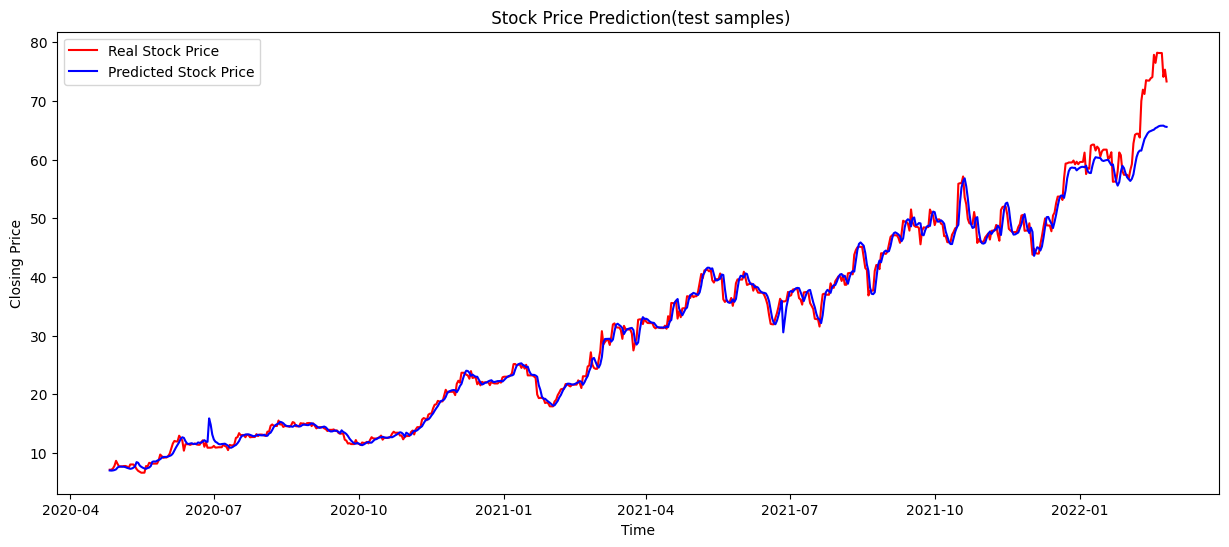

In [84]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
dataframe=data_dict_daybyday_std[stock]
axes.plot(dataframe[len(dataframe)-len(y_test_destd):].index, y_test_destd[:,3], color = 'red', label = 'Real Stock Price')
axes.plot(dataframe[len(dataframe)-len(y_test_destd):].index, y_test_pred_destd[:,3], color = 'blue', label = 'Predicted Stock Price')
plt.title(' Stock Price Prediction(test samples)')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# **QUESTION: 7**

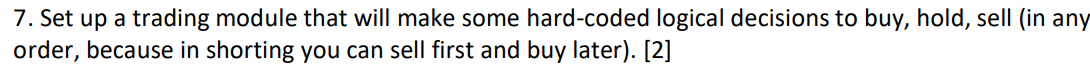

### Below is a trivial strategy that signals **'buy'** if **predicted price > actual price by 2%** and **'sell'** if **predicted price < actual price by 2%**. Profits are calculated after deducting commission as well as bid ask spread from total revenue

In [ ]:
class TradingModule:
    def __init__(self, initial_balance, commission_rate, bid_ask_spread):
        self.balance = initial_balance
        self.position = 0
        self.profit = 0
        self.stock_price = 0
        self.commission_rate = commission_rate  # Commission rate as a decimal (e.g., 0.005 for 0.5%)
        self.bid_ask_spread = bid_ask_spread  # Bid-ask spread as a decimal (e.g., 0.01 for 1%)

    def trade(self, predictions, stock_prices):
        for prediction, stock_price in zip(predictions, stock_prices):
            self.update_stock_price(stock_price)

            if prediction > self.stock_price*1.02:  # Buy if predicted price is 2% higher
                print("buy",prediction,self.stock_price)
                self.buy(10)  # Buy 10 shares
                print("Net_Quantity:",self.position)

            elif prediction < self.stock_price :  # Sell if predicted price is 2% lower
                print("sell",prediction,self.stock_price*0.98)
                self.sell(10)  # Sell 10 shares
                print("Net_Quantity:",self.position)
            else:
                self.hold()

    def update_stock_price(self, stock_price):
        self.stock_price = stock_price

    def buy(self, quantity):
        total_cost = quantity * self.stock_price
        commission = total_cost * self.commission_rate
        bid_ask_spread_cost = total_cost * self.bid_ask_spread
        actual_cost = total_cost + commission + bid_ask_spread_cost
        if actual_cost <= self.balance:
            self.balance -= actual_cost
            self.position += quantity
            #print(self.position)

    def sell(self, quantity):
        #if quantity <= self.position:
            total_revenue = quantity * self.stock_price
            commission = total_revenue * self.commission_rate
            bid_ask_spread_cost = total_revenue * self.bid_ask_spread
            actual_revenue = total_revenue - commission - bid_ask_spread_cost
            self.balance += actual_revenue
            self.position -= quantity
            #print(self.position)
            self.profit += actual_revenue

    def hold(self):
        pass

    def print_summary(self):
        print(f"Final Balance: ${self.balance}")
        print(f"Total Profit: ${self.profit}")
        print(f"Total Shares: {self.position}")
        print(f"final proft/loss(in %): {((self.balance/initial_balance)-1)*100 }")


#               **QUESTION 8**

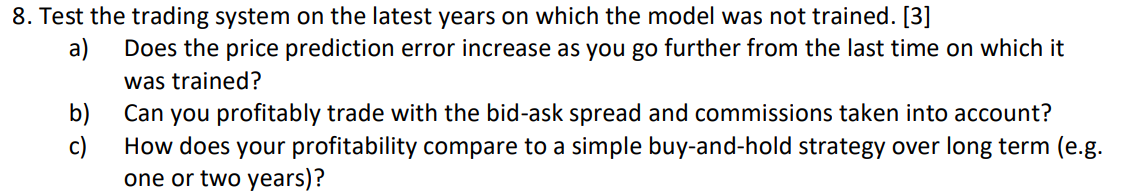

## Ques 8 a) Does the prediction error increase as you go further from the last time on which it was trained

## Prediction error

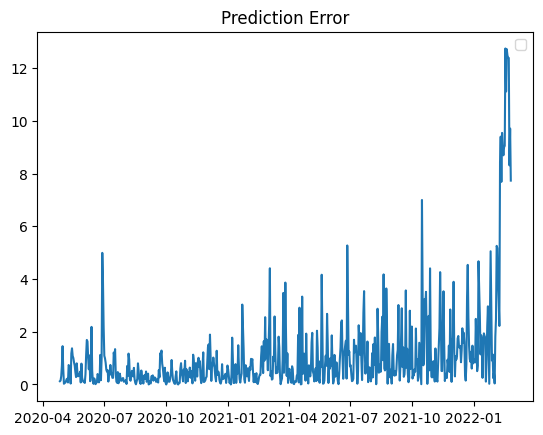

In [85]:
# prediction error
plt.plot(dataframe[len(dataframe)-len(y_test_destd):].index,abs(y_test_destd[:,3]-y_test_pred_destd[:,3]))
plt.title('Prediction Error')
plt.legend()
plt.show()

## CONCLUSION: YES

## Ques 8 b) Can you profitably trade with the bid-ask spread and comissions taken into account?

In [86]:
# Example usage
initial_balance = 10000
commission_rate = 0.005  # 0.1% commission rate
bid_ask_spread = 0.01   # 1% bid-ask spread

trader = TradingModule(initial_balance, commission_rate, bid_ask_spread)

# Example arrays of actual stock prices and predicted prices
actual_prices = y_test_destd[:, 3:4]
predicted_prices = y_test_pred_destd[:, 3:4]

# Make trading decisions based on the predictions and actual prices
trader.trade(predicted_prices, actual_prices)

# Print the final summary
trader.print_summary()


sell [7.029889] [7.011311]
Net_Quantity: -10
sell [7.0060034] [7.011311]
Net_Quantity: -20
sell [7.0347795] [7.206822]
Net_Quantity: -30
sell [7.1015825] [7.666442]
Net_Quantity: -40
sell [7.217698] [8.497678]
Net_Quantity: -50
sell [7.537484] [7.9647536]
Net_Quantity: -60
sell [7.6750555] [7.5784383]
Net_Quantity: -70
sell [7.6652] [7.5784383]
Net_Quantity: -80
sell [7.6629553] [7.6273403]
Net_Quantity: -90
sell [7.5892897] [7.6371403]
Net_Quantity: -100
sell [7.4749994] [7.539336]
Net_Quantity: -110
sell [7.397149] [7.324227]
Net_Quantity: -120
sell [7.313834] [7.8913517]
Net_Quantity: -130
sell [7.363412] [7.8913517]
Net_Quantity: -140
sell [7.5031195] [7.8913517]
Net_Quantity: -150
sell [7.7169924] [7.598037]
Net_Quantity: -160
buy [8.449502] [7.2741003]
Net_Quantity: -150
buy [8.336427] [6.964801]
Net_Quantity: -140
buy [7.8763533] [6.7951994]
Net_Quantity: -130
buy [7.6497946] [6.645499]
Net_Quantity: -120
buy [7.4928236] [6.6554995]
Net_Quantity: -110
buy [7.369445] [6.6554995]


## Here, My total shares are -1860 (negative sign indicates that sells are short(sell first buy later)). I can add the condition in which it will only sell stocks if I have bought them earlier.(Note that in the code (**def sell:**) I have commented that condition -> **if quantity <= self.position:**. Profit seems unusually high because in the real market there are various other factors that might change this result. I have not included the cost of the stocks that have to be bought after shorting
## So in this case It appears that I can trade profitably
## CONCLUSION: YES

# Ques 8 c) How does your profitability compare to a simple buy-and hold strategy over long term(e.g. one or two years)?

In [88]:
import numpy as np

# Define a simple buy-and-hold strategy
def buy_and_hold(initial_balance, initial_price, final_price):
    shares_purchased = initial_balance / initial_price
    final_balance = shares_purchased * final_price
    return final_balance

# Example usage
initial_balance = 10000
commission_rate = 0.005  # 0.1% commission rate
bid_ask_spread = 0.01   # 1% bid-ask spread

trader = TradingModule(initial_balance, commission_rate, bid_ask_spread)

# Example arrays of actual stock prices and predicted prices
actual_prices = y_test_destd[:, 3:4]
predicted_prices = y_test_pred_destd[:, 3:4]

# Make trading decisions based on the predictions and actual prices
trader.trade(predicted_prices, actual_prices)

# Print the final summary for the trading strategy
print("Trading Strategy:")
trader.print_summary()

# Calculate and print the final balance for a buy-and-hold strategy
initial_price = actual_prices[0]  # Initial stock price
final_price = actual_prices[-1]  # Final stock price
final_balance_buy_and_hold = buy_and_hold(initial_balance, initial_price, final_price)
print("\nBuy-and-Hold Strategy:")
print(f"Final Balance: ${final_balance_buy_and_hold}")

# Compare the two strategies
percentage_difference = ((trader.balance - final_balance_buy_and_hold) / final_balance_buy_and_hold) * 100
percentage_difference_scalar = percentage_difference.item()
print(f"\nPercentage Difference: {percentage_difference_scalar:.2f}%")



sell [7.029889] [7.011311]
Net_Quantity: -10
sell [7.0060034] [7.011311]
Net_Quantity: -20
sell [7.0347795] [7.206822]
Net_Quantity: -30
sell [7.1015825] [7.666442]
Net_Quantity: -40
sell [7.217698] [8.497678]
Net_Quantity: -50
sell [7.537484] [7.9647536]
Net_Quantity: -60
sell [7.6750555] [7.5784383]
Net_Quantity: -70
sell [7.6652] [7.5784383]
Net_Quantity: -80
sell [7.6629553] [7.6273403]
Net_Quantity: -90
sell [7.5892897] [7.6371403]
Net_Quantity: -100
sell [7.4749994] [7.539336]
Net_Quantity: -110
sell [7.397149] [7.324227]
Net_Quantity: -120
sell [7.313834] [7.8913517]
Net_Quantity: -130
sell [7.363412] [7.8913517]
Net_Quantity: -140
sell [7.5031195] [7.8913517]
Net_Quantity: -150
sell [7.7169924] [7.598037]
Net_Quantity: -160
buy [8.449502] [7.2741003]
Net_Quantity: -150
buy [8.336427] [6.964801]
Net_Quantity: -140
buy [7.8763533] [6.7951994]
Net_Quantity: -130
buy [7.6497946] [6.645499]
Net_Quantity: -120
buy [7.4928236] [6.6554995]
Net_Quantity: -110
buy [7.369445] [6.6554995]


## CONCLUSION: Thus in this case, buy and hold strategy for a long period makes more profit. But in real scenario, there are various other charges for following these type of strategy and thus actual profit might be lower then this


#                                           **QUESTION 9**








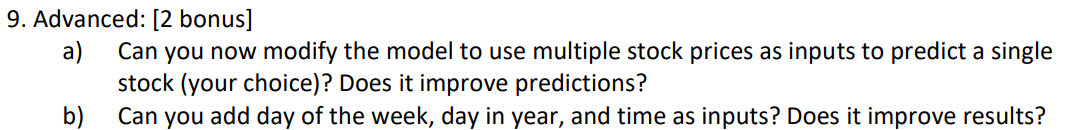

# Ques 9 a) Can you now modify the model to use multiple stock prices as inputs to predict a single stock(your choice)? Does it improve predictions?

## Hypothesis: I have used AVGO(Broadcom) as an additional related stock with AAPL because broadcom provides electrical components to APPLE and recently they came in a multibillion deal with apple, so we can expect AVGO to have some correlation with AAPL.

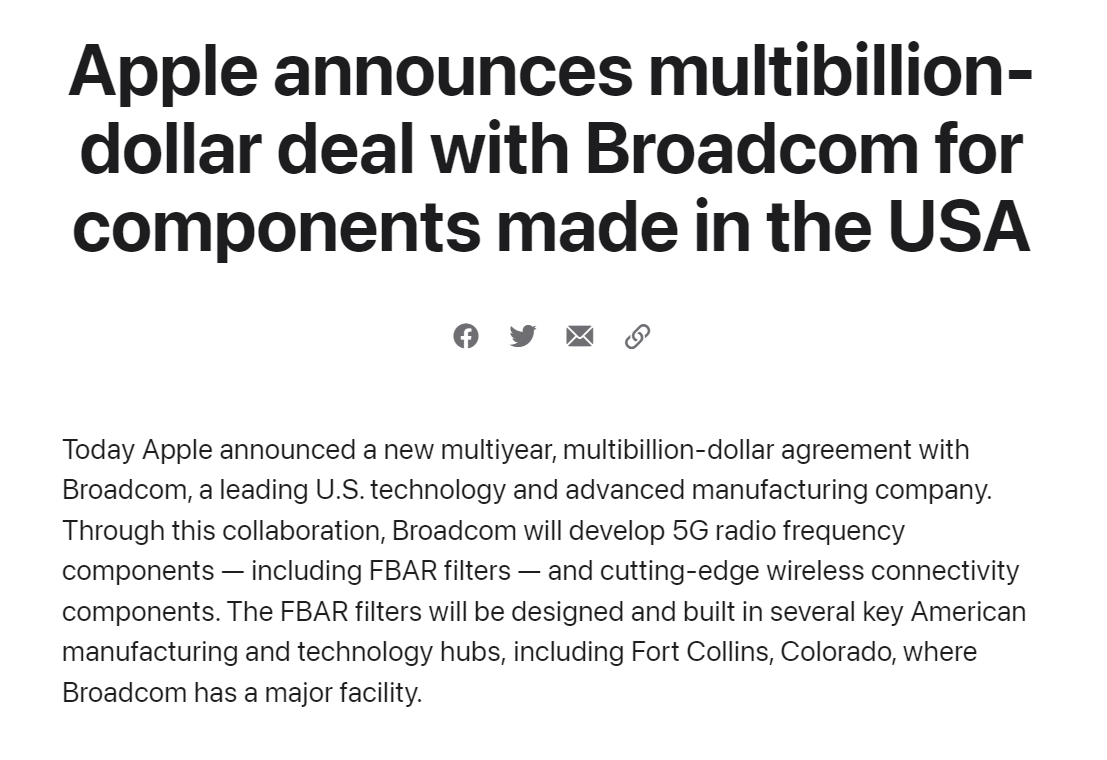

In [92]:
# Extract the closing price columns from each DataFrame
aapl_close = data_dict_daybyday_std['AAPL']['Close']
avgo_close = data_dict_daybyday_std['AVGO']['Close']
aa_close = data_dict_daybyday_std['AA']['Close']

# Create a new DataFrame with the closing prices of all stocks
closing_prices = pd.DataFrame({
    'AAPL': aapl_close,
    'AVGO': avgo_close,
    'AA': aa_close
})

# Calculate the correlation matrix
correlation_matrix = closing_prices.corr()
correlation_matrix

,AAPL,AVGO,AA
AAPL,1.000000,0.965539,0.101179
AVGO,0.965539,1.000000,0.209582
AA,0.101179,0.209582,1.000000


## Our hypothesis turned out true!!! There is a high correlation between AAPL and AVGO(0.9655)
##  So, we will try to predict prices of AAPL based on the price of AVGO below

In [96]:
data_dict_daybyday_std["AAPL"]

,Open,High,Low,Close,Volume
Timestamp,,,,,
2016-10-18,-1.067214,-1.067463,-1.067491,-1.067722,-0.075992
2016-10-19,-1.069080,-1.069273,-1.069039,-1.069109,-0.277313
2016-10-20,-1.069666,-1.069647,-1.069466,-1.069643,-0.172778
2016-10-21,-1.071854,-1.072100,-1.072135,-1.071884,0.090166
2016-10-22,-1.072174,-1.072420,-1.071975,-1.072203,-0.784147
...,...,...,...,...,...
2022-02-21,2.103686,2.102626,2.106414,2.105033,-0.784753
2022-02-22,2.055090,2.060672,2.057780,2.061909,-0.035791
2022-02-23,1.958355,1.968556,1.960739,1.965851,0.247312


## 1) Training and testing for AVGO without considering AAPL

In [130]:
# load_stock_data takes (close,open,high,low,volume) of one or more stocks as input and split the dataset accordingly
[x_train_single, y_train_single, x_test_single, y_test_single]=load_stock_data(data_dict_daybyday_std, stock="AAPL", stock_features=['Open', 'High', 'Low', 'Close', 'Volume'],related_stocks=[],look_back=60
                                                                               ,future_horizon=1)
x_train_single_tensor = torch.from_numpy(x_train_single).type(torch.Tensor)
x_test_single_tensor = torch.from_numpy(x_test_single).type(torch.Tensor)
y_train_single_tensor = torch.from_numpy(y_train_single).type(torch.Tensor)
y_test_single_tensor = torch.from_numpy(y_test_single).type(torch.Tensor)

In [131]:
stock = "AAPL"
input_dim = 5
hidden_dim = 32
output_dim = 5
num_layers = 2
model, y_train_single__pred_tensor = training(stock,x_train_single_tensor,y_train_single_tensor,input_dim, hidden_dim, output_dim, num_layers)

Training for AAPL starts
Epoch  10 MSE:  0.3022167980670929
Epoch  20 MSE:  0.25202763080596924
Epoch  30 MSE:  0.2460363358259201
Epoch  40 MSE:  0.24290798604488373
Epoch  50 MSE:  0.24089007079601288
Epoch  60 MSE:  0.238021582365036
Epoch  70 MSE:  0.23269349336624146
Epoch  80 MSE:  0.2237071841955185
Epoch  90 MSE:  0.2160940021276474


In [132]:
y_test_destd,y_test_pred_destd=test_model(stock=stock,model=model,scaler=data_dict_daybyday_scaled[stock],y_train_pred_tensor=y_train_single__pred_tensor,y_train_tensor=y_train_single_tensor,x_test_tensor=x_test_single_tensor,y_test_tensor=y_test_single_tensor)

Train Score: 1.87 RMSE
Test Score: 52.40 RMSE


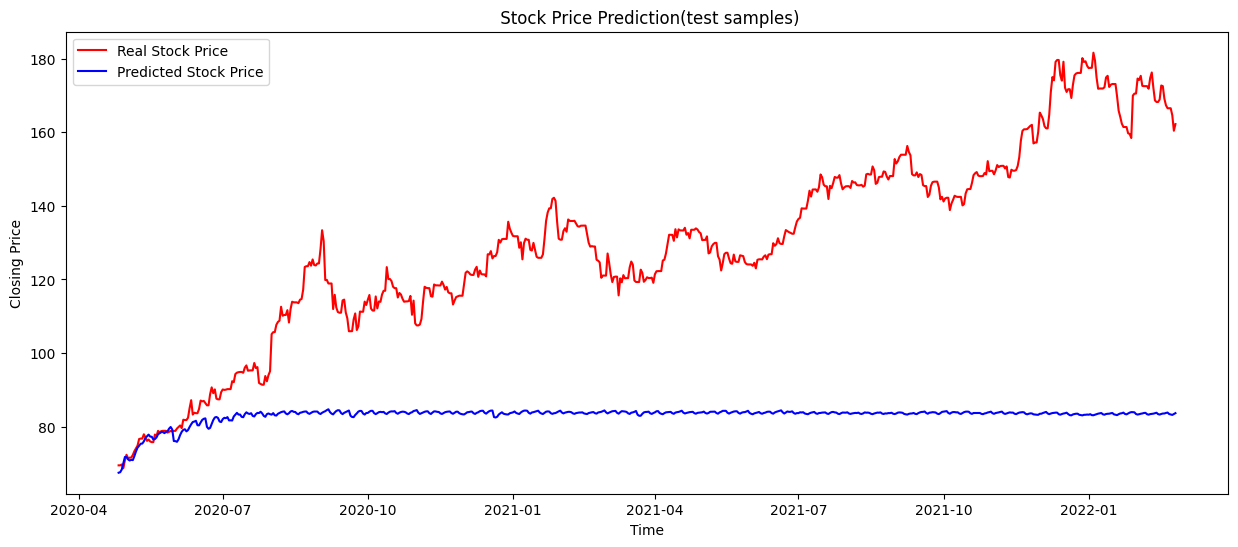

In [133]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
dataframe=data_dict_daybyday_std[stock]
axes.plot(dataframe[len(dataframe)-len(y_test_destd):].index, y_test_destd[:,3], color = 'red', label = 'Real Stock Price')
axes.plot(dataframe[len(dataframe)-len(y_test_destd):].index, y_test_pred_destd[:,3], color = 'blue', label = 'Predicted Stock Price')
plt.title(' Stock Price Prediction(test samples)')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

## 2) Training and testing for AVGO with AAPL

In [125]:
# load_stock_data takes (close,open,high,low,volume) of one or more stocks as input and split the dataset accordingly
[x_train_multi, y_train_multi, x_test_multi, y_test_multi]=load_stock_data(data_dict_daybyday_std, stock="AAPL", stock_features=['Open', 'High', 'Low', 'Close', 'Volume'],related_stocks=["AVGO"],related_stocks_features=['Open', 'High', 'Low', 'Close', 'Volume']
                                                                           ,look_back=60,future_horizon=1)
x_train_multi_tensor = torch.from_numpy(x_train_multi).type(torch.Tensor)
x_test_multi_tensor = torch.from_numpy(x_test_multi).type(torch.Tensor)
y_train_multi_tensor = torch.from_numpy(y_train_multi).type(torch.Tensor)
y_test_multi_tensor = torch.from_numpy(y_test_multi).type(torch.Tensor)

In [104]:
x_train_multi_tensor.shape

torch.Size([1225, 60, 10])

In [126]:
stock = "AAPL"
input_dim = 10
hidden_dim = 32
output_dim = 5
num_layers = 2
model, y_train_multi__pred_tensor = training(stock,x_train_multi_tensor,y_train_multi_tensor,input_dim, hidden_dim, output_dim, num_layers)

Training for AAPL starts
Epoch  10 MSE:  0.2901180684566498
Epoch  20 MSE:  0.25169211626052856
Epoch  30 MSE:  0.24616190791130066
Epoch  40 MSE:  0.24204906821250916
Epoch  50 MSE:  0.2388993203639984
Epoch  60 MSE:  0.2328050434589386
Epoch  70 MSE:  0.22363896667957306
Epoch  80 MSE:  0.20930087566375732
Epoch  90 MSE:  0.19278937578201294


In [127]:
y_test_destd,y_test_pred_destd=test_model(stock=stock,model=model,scaler=data_dict_daybyday_scaled[stock],y_train_pred_tensor=y_train_multi__pred_tensor,y_train_tensor=y_train_multi_tensor,x_test_tensor=x_test_multi_tensor,y_test_tensor=y_test_multi_tensor)

Train Score: 2.60 RMSE
Test Score: 48.52 RMSE


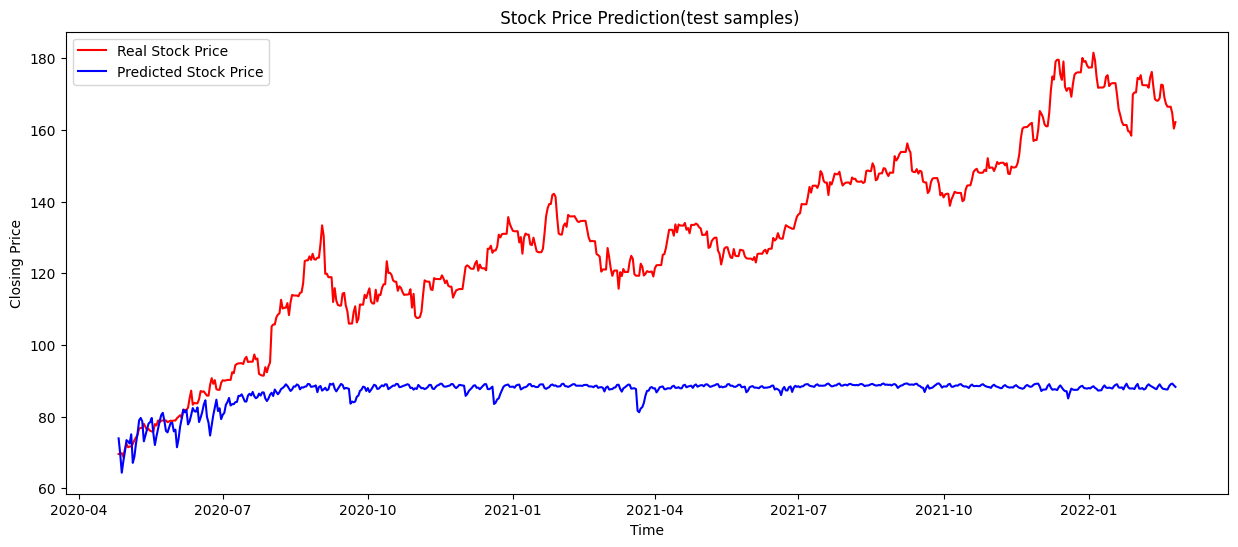

In [129]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
dataframe=data_dict_daybyday_std[stock]
axes.plot(dataframe[len(dataframe)-len(y_test_destd):].index, y_test_destd[:,3], color = 'red', label = 'Real Stock Price')
axes.plot(dataframe[len(dataframe)-len(y_test_destd):].index, y_test_pred_destd[:,3], color = 'blue', label = 'Predicted Stock Price')
plt.title(' Stock Price Prediction(test samples)')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

## As expected, **Test error for AAPL without considering AVGO(52.40 RMSE) > Test error for AAPL considering AVGO(48.52 RMSE)**. Though the predictions for AAPL are in general very poor due to various other reasons, but the point was to show that combining stocks can enance prediction accuracy
## CONCLUSION: ACCURACY IMPROVED!

## Ques 9 b) Can you add day of the week,day in year, and time as inputs? Does it improve results?

In [170]:
import numpy as np
import pandas as pd
import torch

def load_stock_data_with_timestamps(dataframes, stock, related_stocks=[],
                    stock_features=['Open', 'High', 'Low', 'Close', 'Volume'],
                    related_stocks_features=[],
                    look_back=60, future_horizon=1):

    def final_data():
        dataframe_stock = dataframes[stock]
        dataframe_stock['day_of_week'] = dataframe_stock.index.dayofweek
        dataframe_stock['day_in_year'] = dataframe_stock.index.dayofyear
        dataframe_stock['time'] = dataframe_stock.index.time
        data_raw = pd.concat([dataframe_stock[stock_features], dataframe_stock[['day_of_week', 'day_in_year']]], axis=1)  # Exclude 'time'
        data_raw = data_raw.values  # Convert to numpy array
        return data_raw

    data_raw = final_data()
    data = []

    for index in range(len(data_raw) - look_back - future_horizon):
        data.append(data_raw[index: index + look_back + future_horizon])

    data = np.array(data, dtype=np.float32)  # Ensure the data type is compatible with torch

    test_set_size = int(np.round(0.354 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    x_train = data[:train_set_size, :-future_horizon, :]
    y_train = data[:train_set_size, -1, :len(stock_features)]

    x_test = data[train_set_size:, :-future_horizon, :]
    y_test = data[train_set_size:, -1, :len(stock_features)]

    return x_train, y_train, x_test, y_test

# Example usage:
# dataframes = {'AAPL': pd.DataFrame(), 'AA': pd.DataFrame(), 'AVGO': pd.DataFrame()}
# stock = 'AAPL'
# additional_stocks = ['AA', 'AVGO']
# x_train, y_train, x_test, y_test = load_stock_data_with_timestamps(dataframes, stock, additional_stocks)


In [171]:
# load_stock_data takes (close,open,high,low,volume) of one or more stocks as input and split the dataset accordingly
[x_train, y_train, x_test, y_test]=load_stock_data_with_timestamps(data_dict_daybyday_std, stock="AA",stock_features=['Open', 'High', 'Low', 'Close', 'Volume'],related_stocks=[],look_back=60,future_horizon=1)
x_train_tensor = torch.from_numpy(x_train).type(torch.Tensor)
x_test_tensor = torch.from_numpy(x_test).type(torch.Tensor)
y_train_tensor = torch.from_numpy(y_train).type(torch.Tensor)
y_test_tensor = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
x_train_tensor.shape

In [175]:
stock = "AA"
input_dim = 7
hidden_dim = 32
output_dim = 5
num_layers = 2
model, y_train_pred_tensor = training(stock,x_train_tensor,y_train_tensor,input_dim, hidden_dim, output_dim, num_layers)

Training for AA starts
Epoch  10 MSE:  0.2942119240760803
Epoch  20 MSE:  0.11796518415212631
Epoch  30 MSE:  0.05808412283658981
Epoch  40 MSE:  0.04776664823293686
Epoch  50 MSE:  0.038610704243183136
Epoch  60 MSE:  0.03464693948626518
Epoch  70 MSE:  0.0322301983833313
Epoch  80 MSE:  0.031039167195558548
Epoch  90 MSE:  0.030386721715331078


In [176]:
y_test_destd,y_test_pred_destd=test_model(stock=stock,model=model,scaler=data_dict_daybyday_scaled[stock],y_train_pred_tensor=y_train_pred_tensor,y_train_tensor=y_train_tensor,x_test_tensor=x_test_tensor,y_test_tensor=y_test_tensor)

Train Score: 1.08 RMSE
Test Score: 4.55 RMSE


## In this case, the Test error has increased after adding day of the week, day in year, and time as inputs.Thus, there is no improvement in result at all
## CONCLUSION: NO IMPROVEMENT


## **ADDITIONAL TRADING STRATEGIES**

## **I tried various strategies like Mean reversion strategy, Momentum trading strategy and Golden Crossover strategy to get maximum profits but only golden crossover strategy gave Sharpe Ratio >1 in my case**

# GOLDEN CROSSOVER STRATEGY

In [242]:
import numpy as np
predicted_prices = y_test_pred_destd[:,3:4]

# Initialize portfolio variables
initial_cash_balance = 100000  # Starting cash balance
cash_balance = initial_cash_balance
stocks_held = 0
risk_limit = 0.02  # Maximum percentage of portfolio to risk on a single trade
short_window = 50
long_window = 200
bid_ask_spread = 0.01  # Example bid-ask spread as a percentage (adjust as needed)
commission_rate = 0.005  # Example commission rate as a percentage (adjust as needed)

# Initialize variables for tracking portfolio metrics
portfolio_value = [initial_cash_balance]
returns = [0]

# Iterate through predicted prices
for i in range(len(predicted_prices)):
    current_price = predicted_prices[i]

    # Calculate moving averages
    if i >= long_window - 1:
        short_ma = np.mean(predicted_prices[i - short_window + 1 : i + 1])
        long_ma = np.mean(predicted_prices[i - long_window + 1 : i + 1])

        # Implement the Golden Crossover strategy
        if short_ma > long_ma:
            # Calculate the position size based on available cash and risk limit
            max_position_size = cash_balance * risk_limit
            position_size = np.minimum(max_position_size, cash_balance)

            # Calculate transaction cost
            transaction_cost = (1 + bid_ask_spread) * current_price * commission_rate
            cost = position_size * current_price + transaction_cost

            # Execute the buy order if within risk limit
            if np.all(np.less_equal(cost, cash_balance)):
                cash_balance -= cost
                stocks_held += position_size

        elif short_ma < long_ma:
            # Calculate position size based on stocks held
            position_size = stocks_held

            # Calculate transaction cost
            transaction_cost = (1 - bid_ask_spread) * current_price * commission_rate
            earnings = position_size * current_price - transaction_cost

            # Execute the sell order if within risk limit
            if np.all(np.less_equal(earnings, cash_balance)):
                cash_balance += earnings
                stocks_held -= position_size

    # Calculate portfolio value and returns
    portfolio_value.append(cash_balance + stocks_held * current_price)
    returns.append((portfolio_value[-1] - initial_cash_balance) / initial_cash_balance)




In [245]:
# Calculate overall portfolio statistics
portfolio_value = np.array(portfolio_value)  # Ensure it's a numpy array
returns = np.array(returns)  # Ensure it's a numpy array

# Calculate daily returns from portfolio values
daily_returns = (portfolio_value[1:] - portfolio_value[:-1]) / portfolio_value[:-1]

# Calculate portfolio statistics
annualized_return = np.mean(daily_returns) * 252  # Assumes 252 trading days in a year
annualized_volatility = np.std(daily_returns) * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility

print("Annualized Return:", annualized_return)
print("Annualized Volatility:", annualized_volatility)
print("Sharpe Ratio:", sharpe_ratio)

# Calculate net portfolio value
net_portfolio_value = portfolio_value[-1]  # The last value in the portfolio_value array
print("Net Portfolio Value:", net_portfolio_value)


Annualized Return: [0.59315337]
Annualized Volatility: [0.32333789]
Sharpe Ratio: [1.83446913]
Net Portfolio Value: [420477.02857295]


## This strategy gives a sharpe ratio of 1.83 which is quite good and implies that it is a profitable strategy and the net portfolio value has also increased to 420477 from 100000

# **REFERENCES**
Candlestick charts:

 https://www.geeksforgeeks.org/how-to-create-a-candlestick-chart-in-matplotlib/

https://stackoverflow.com/questions/64689342/plotly-how-to-add-volume-to-a-candlestick-chart

LSTM:
https://www.kaggle.com/code/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch/notebook

https://www.apple.com/newsroom/2023/05/apple-announces-multibillion-dollar-deal-with-broadcom/

ChatGPT
